In [ ]:
from sklearn.datasets import fetch_california_housing
! pip install keras-tuner

# Load dataset
data = fetch_california_housing(as_frame=True)
df = data.frame  # Converts to a pandas DataFrame

# View the first few rows
print(df.head())


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.4 MB/s eta 0:00:00
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseVal  
0    -122.23        4.526  
1    -122.22        3.585  
2    -122.24        3.521  
3    -122.25        3.413  
4    -122.25        3.422  


In [ ]:
! pip install keras_tuner

Trial 5 Complete [00h 00m 17s]
mse: 0.4670611023902893

Best mse So Far: 0.4582555592060089
Total elapsed time: 00h 01m 20s
Epoch 1/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8905 - mse: 0.8905 - val_loss: 0.4540 - val_mse: 0.4540
Epoch 2/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5055 - mse: 0.5055 - val_loss: 0.4013 - val_mse: 0.4013
Epoch 3/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4498 - mse: 0.4498 - val_loss: 0.4257 - val_mse: 0.4257
Epoch 4/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4669 - mse: 0.4669 - val_loss: 0.3988 - val_mse: 0.3988
Epoch 5/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4790 - mse: 0.4790 - val_loss: 0.3751 - val_mse: 0.3751
Epoch 6/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4340 - mse: 0.4340 - val_loss: 0.3686 - val_mse: 0.3686
Epoch 7/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4838 - mse: 0.4838 - val_loss: 0.3805 - val_mse: 0.3805
Epoch 8/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/ste

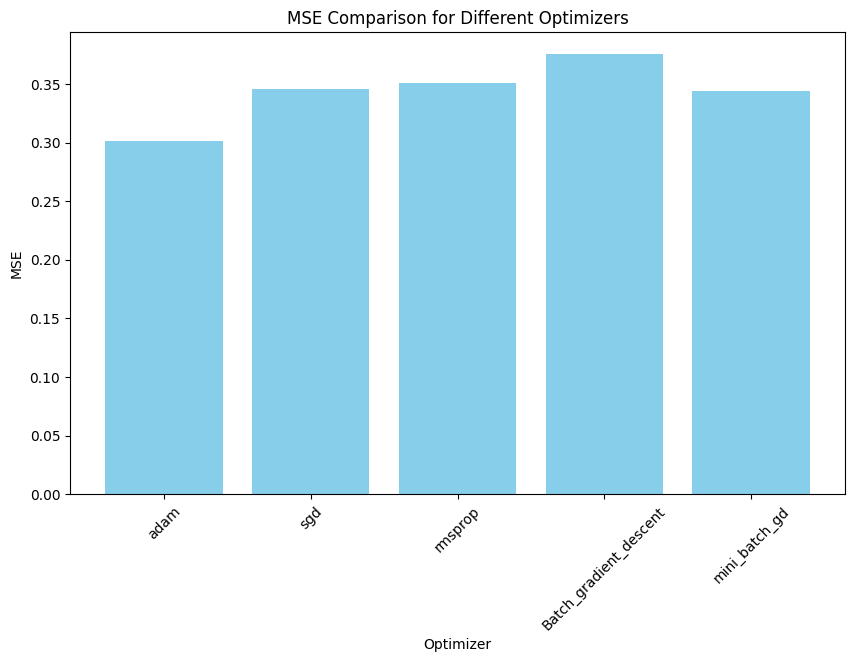


The best optimizer is: adam with MSE: 0.3011


In [ ]:
import tensorflow as tf
import keras_tuner as kt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load and preprocess the dataset
data = fetch_california_housing(as_frame=True)
X = data.frame.drop(columns=['MedHouseVal'])
y = data.frame['MedHouseVal']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to TensorFlow tensors
X_train_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tf = tf.convert_to_tensor(y_train.values, dtype=tf.float32)
X_test_tf = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test_tf = tf.convert_to_tensor(y_test.values, dtype=tf.float32)

# Store results for comparison
optimizer_results = {}

# Define the model builder function
def build_model(hp):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(hp.Int('units_1', min_value=64, max_value=128, step=64), activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(hp.Int('units_2', min_value=32, max_value=64, step=32), activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1)  # Output layer for regression
    ])

    # Choose optimizer and its hyperparameters
    optimizer_choice = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop', 'Batch_gradient_descent', 'mini_batch_gd'])

    if optimizer_choice == 'adam':
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', [0.001, 0.01])
        )
    elif optimizer_choice == 'sgd':
        optimizer = tf.keras.optimizers.SGD(
            learning_rate=hp.Choice('learning_rate', [0.001, 0.01]),
            momentum=hp.Choice('momentum', [0.0, 0.5])
        )
    elif optimizer_choice == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(
            learning_rate=hp.Choice('learning_rate', [0.001, 0.01]),
            rho=hp.Choice('rho', [0.9])
        )
    elif optimizer_choice == 'Batch_gradient_descent':
        optimizer = tf.keras.optimizers.SGD(
            learning_rate=hp.Choice('learning_rate', [0.01, 0.1])
        )  # Full Batch Gradient Descent
    elif optimizer_choice == 'mini_batch_gd':
        optimizer = tf.keras.optimizers.SGD(
            learning_rate=hp.Choice('learning_rate', [0.01, 0.1])
        )  # Mini-batch Gradient Descent

    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mse']
    )
    return model

# Function to perform tuning for each optimizer
def tune_optimizer(optimizer_name):
    # Initialize the tuner with a specific optimizer
    tuner = kt.RandomSearch(
        build_model,
        objective='mse',
        max_trials=5,
        executions_per_trial=1,
        directory=f'optimizer_tuning_{optimizer_name}',
        project_name=f'{optimizer_name}_comparison'
    )

    try:
        tuner.search(X_train_tf, y_train_tf, epochs=10, validation_split=0.2, verbose=1)
        best_hps = tuner.get_best_hyperparameters(1)[0]
        best_model = tuner.hypermodel.build(best_hps)

        # Train the best model
        early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, verbose=1)
        history = best_model.fit(
            X_train_tf, y_train_tf,
            epochs=20,
            validation_split=0.2,
            batch_size=32,
            verbose=1,
            callbacks=[early_stopping]
        )

        # Evaluate on test data
        test_mse = best_model.evaluate(X_test_tf, y_test_tf, verbose=1)[1]
        optimizer_results[optimizer_name] = test_mse

        print(f"Optimizer: {optimizer_name}, Test MSE: {test_mse:.4f}")
    except Exception as e:
        print(f"Error with optimizer {optimizer_name}: {e}")
        optimizer_results[optimizer_name] = None

# Perform tuning for all optimizers
for optimizer in ['adam', 'sgd', 'rmsprop', 'Batch_gradient_descent', 'mini_batch_gd']:
    tune_optimizer(optimizer)

# Display the results
print("\nOptimizer Results:")
for optimizer, mse in optimizer_results.items():
    print(f"{optimizer}: {mse}")

# Plot Bar Graph for MSE Comparison
plt.figure(figsize=(10, 6))
optimizers = list(optimizer_results.keys())
mse_values = [mse if mse is not None else float('inf') for mse in optimizer_results.values()]
plt.bar(optimizers, mse_values, color='skyblue')
plt.title('MSE Comparison for Different Optimizers')
plt.xlabel('Optimizer')
plt.ylabel('MSE')
plt.xticks(rotation=45)
plt.show()

# Print the best optimizer
valid_results = {k: v for k, v in optimizer_results.items() if v is not None}
if valid_results:
    best_optimizer = min(valid_results, key=valid_results.get)
    print(f"\nThe best optimizer is: {best_optimizer} with MSE: {valid_results[best_optimizer]:.4f}")
else:
    print("\nNo valid results to determine the best optimizer.")


Reloading Tuner from optimizer_tuning_adam/adam_comparison/tuner0.json
Epoch 1/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 1.1534 - mse: 1.1534 - val_loss: 0.4551 - val_mse: 0.4551
Epoch 2/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.5847 - mse: 0.5847 - val_loss: 0.4262 - val_mse: 0.4262
Epoch 3/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.5036 - mse: 0.5036 - val_loss: 0.3975 - val_mse: 0.3975
Epoch 4/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.4638 - mse: 0.4638 - val_loss: 0.3989 - val_mse: 0.3989
Epoch 5/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.4518 - mse: 0.4518 - val_loss: 0.3804 - val_mse: 0.3804
Epoch 6/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.4301 - mse: 0.4301 - val_loss: 0.3744 - val_mse: 0.3744
Epoch 7/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.4286 - mse: 0.4286 - val_loss: 0.3644 - val_mse: 0.3644
Epoch 8/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3944 - mse: 0.3944 - val_loss: 0.4121 - 

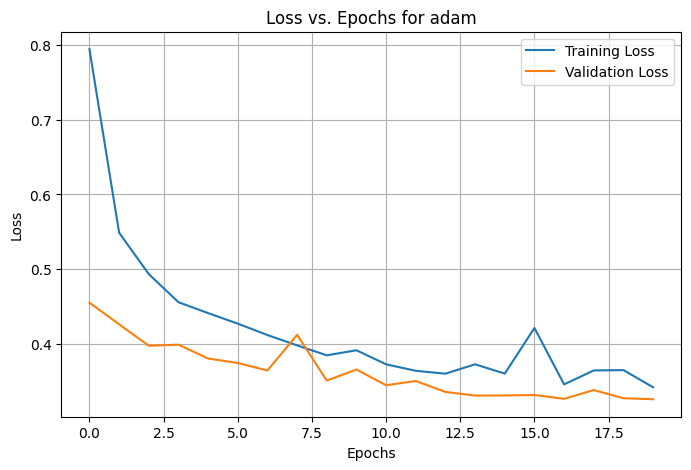

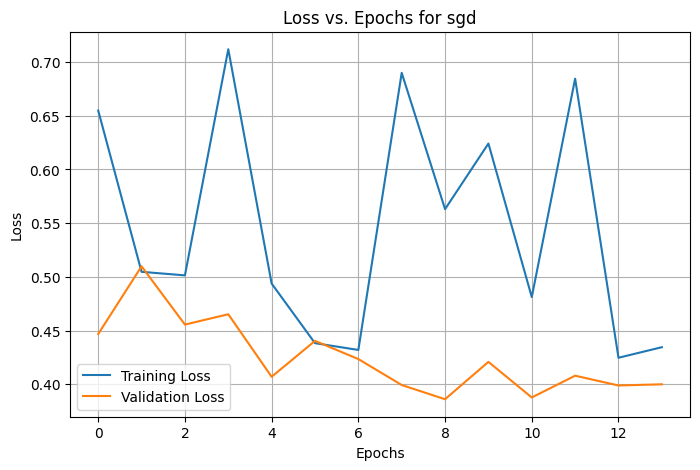

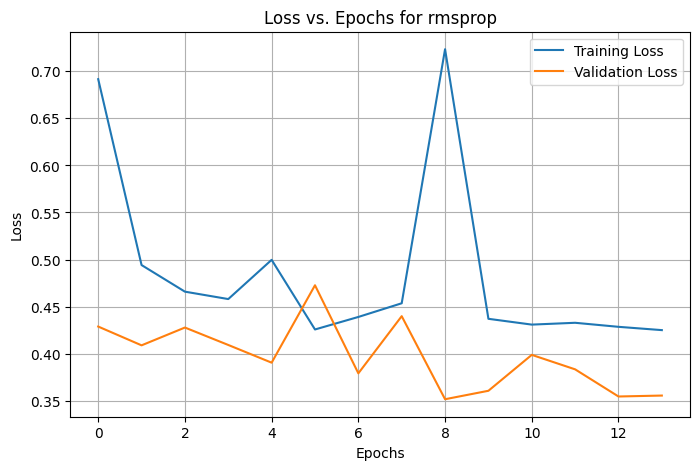

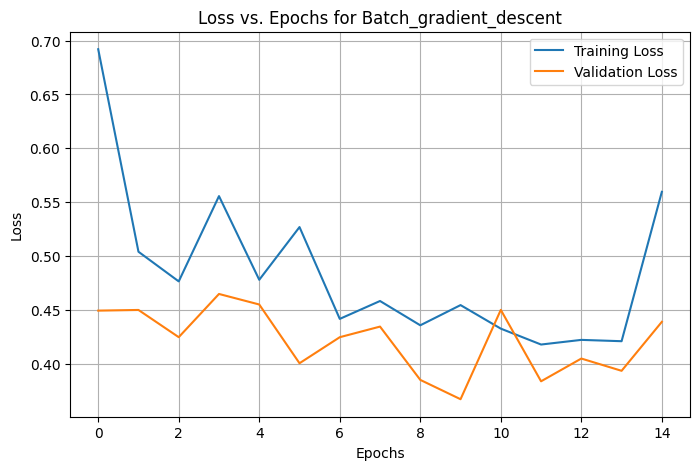

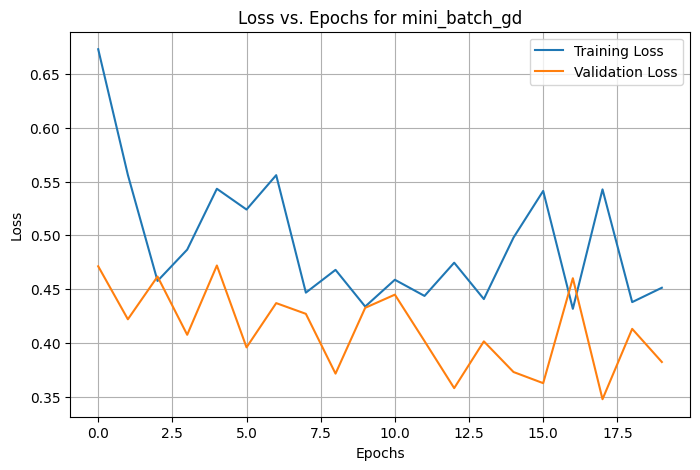


The best optimizer is: adam with MSE: 0.3094


In [ ]:
# Dictionary to store training history for each optimizer
history_results = {}

# Function to perform tuning for each optimizer and save history
def tune_optimizer_with_history(optimizer_name):
    # Initialize the tuner with a specific optimizer
    tuner = kt.RandomSearch(
        build_model,
        objective='mse',
        max_trials=5,
        executions_per_trial=1,
        directory=f'optimizer_tuning_{optimizer_name}',
        project_name=f'{optimizer_name}_comparison'
    )

    try:
        tuner.search(X_train_tf, y_train_tf, epochs=10, validation_split=0.2, verbose=1)
        best_hps = tuner.get_best_hyperparameters(1)[0]
        best_model = tuner.hypermodel.build(best_hps)

        # Train the best model
        early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, verbose=1)
        history = best_model.fit(
            X_train_tf, y_train_tf,
            epochs=20,
            validation_split=0.2,
            batch_size=32,
            verbose=1,
            callbacks=[early_stopping]
        )

        # Save the history for plotting
        history_results[optimizer_name] = history

        # Evaluate on test data
        test_mse = best_model.evaluate(X_test_tf, y_test_tf, verbose=1)[1]
        optimizer_results[optimizer_name] = test_mse

        print(f"Optimizer: {optimizer_name}, Test MSE: {test_mse:.4f}")
    except Exception as e:
        print(f"Error with optimizer {optimizer_name}: {e}")
        optimizer_results[optimizer_name] = None

# Perform tuning for all optimizers and store their histories
for optimizer in ['adam', 'sgd', 'rmsprop', 'Batch_gradient_descent', 'mini_batch_gd']:
    tune_optimizer_with_history(optimizer)

# Plot Loss vs. Epochs for each optimizer
for optimizer, history in history_results.items():
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss vs. Epochs for {optimizer}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

# Display the best optimizer
valid_results = {k: v for k, v in optimizer_results.items() if v is not None}
if valid_results:
    best_optimizer = min(valid_results, key=valid_results.get)
    print(f"\nThe best optimizer is: {best_optimizer} with MSE: {valid_results[best_optimizer]:.4f}")
else:
    print("\nNo valid results to determine the best optimizer.")
